In [ ]:
# pip install yfinance

[*********************100%***********************]  1 of 1 completed


Volatilité : 0.22603468035822386
Rendement moyen : 1.8643031088259748e-05


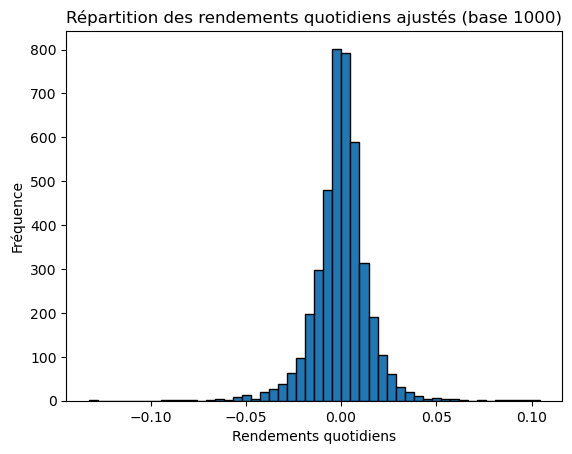

In [156]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Télécharger les données historiques de l'EURO STOXX 50
ticker = "^STOXX50E"
data = yf.download(ticker, start="2000-01-01", end="2024-01-01", interval="1d")

# Extraire les prix de clôture pour les simulations
close_prices = data['Close']

# Ajuster les prix de clôture pour qu'ils commencent à 1000
# 1000 étant la valeur du portefeuille
initial_price = close_prices.iloc[-1]  # Prix de clôture initial (dernier jour  de data disponible pour prédire le futur)
close_prices = close_prices / initial_price * 1000

# Calculer les rendements journaliers
returns = np.log(close_prices / close_prices.shift(1)).dropna()

# Calculer la volatilité et le rendement moyen annualisé
volatility = returns.std() * (252 ** 0.5)  # Volatilité annuelle
mean_return = returns.mean()

print(f"Volatilité : {volatility}")
print(f"Rendement moyen : {mean_return}")

# Visualiser la répartition des rendements quotidiens ajustés
plt.hist(returns, bins=50, edgecolor='black')
plt.title('Répartition des rendements quotidiens ajustés (base 1000)')
plt.xlabel('Rendements quotidiens')
plt.ylabel('Fréquence')
plt.show()

# Les rendements logarithmique semble bien suivre une répartition normale
# L'utilisation de black and scholes serait donc cohérente

In [157]:
# Paramètres de la simulation
S0 = close_prices.iloc[-1]  # Dernier prix de clôture
T = 3  # Durée en années (3 ans)
n_simulations = 10000  # Nombre de simulations
n_steps = 252 * T  # Nombre de dates d'évaluation (chaque trimestre sur 3 ans)
dt = T / n_steps  # Pas de temps

# Fonction pour générer des chemins simulés
def generate_paths(S0, mean_return, volatility, T, n_steps, n_simulations):
    paths = np.zeros((n_steps + 1, n_simulations))
    paths[0] = S0

    # Le mouvement simulé est un mouvement Brownien Géometrique
    #  Formule du mouvement brownien géométrique (GBM) :
    # dS_t = mu * S_t * dt + sigma * S_t * dW_t
    
    # Solution discrétisée de cette équation stochastique :
    # S(t+1) = S(t) * exp[(mu - 0.5 * sigma^2) * dt + sigma * sqrt(dt) * Z]
    
    for t in range(1, n_steps + 1):
        Z = np.random.normal(loc=mean_return, scale=volatility, size=n_simulations)
        paths[t] = paths[t-1] * np.exp((mean_return - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * Z)
        # Retourne paths : Un tableau NumPy contenant les trajectoires de prix simulées
        # Paths[t] est un vecteur de taile (1,n_simulations)
    return paths

# Générer les chemins simulés du sous-jacent
paths = generate_paths(S0, mean_return, volatility, T, n_steps, n_simulations)

# Sélectionner les prix trimestriellement, soit tous les 63 jours environ
trimestrial_steps = np.arange(0, n_steps +1 , 63)
paths_trimestrial = paths[trimestrial_steps]
print("paths_trimestrial contient bien" ,len(paths_trimestrial), "éléments")
paths_trimestrial[-1]

paths_trimestrial contient bien 13 éléments


array([ 883.06456322, 1150.40145741,  865.8290367 , ..., 1000.27530152,
        998.18210014,  946.1572879 ])

In [158]:
# Calcul remboursement anticipé
# Paramètres liés au remboursement anticipé
remboursement_anticipe_taux = 2.55 / 100  # Taux de 2.55% par période
n_steps = 12  # 12 trimestres sur 3 ans

# Initialiser une variable pour stocker le montant remboursé par anticipation
early_redemption = np.zeros(n_simulations)

# Vérifier à chaque trimestre si la performance est positive pour un remboursement anticipé
for i in range(1, n_steps):
    # Calcul de la performance à l'instant t par rapport à la valeur initiale S0
    performance_i = (paths_trimestrial[i] / S0) - 1
    
    # Si la performance est supérieure ou égale à 0, alors remboursement anticipé
    redemption = np.where(performance_i >= 0, 1000 * (1 + i * remboursement_anticipe_taux), 0)
    
    # Si un remboursement anticipé est calculé, on ne doit plus ajouter à chaque période
    early_redemption = np.where(early_redemption == 0, redemption, early_redemption)
    
    # Limiter le remboursement anticipé à 1306 EUR maximum
    early_redemption = np.where(early_redemption > 1306, 1306, early_redemption)
    
# Si un remboursement anticipé a eu lieu, il faut sortir du produit (mettre les autres à 0)
early_redemption_flag = early_redemption > 0
# Si un remboursement anticipé a eu lieu, on remplace les valeurs par la valeur anticipée dans paths (pas journaliers)
# Remplacer les valeurs journalières dans paths après un remboursement anticipé
for i in range(1, len(trimestrial_steps)):  # Boucle sur les trimestres
    start_idx = trimestrial_steps[i-1]  # Début du trimestre
    end_idx = trimestrial_steps[i]  # Fin du trimestre
    redemption_value = 1000 * (1 + i * remboursement_anticipe_taux)  # Calcul du remboursement anticipé
    
    # Remplacer toutes les valeurs journalières dans paths par la valeur anticipée pour les simulations avec remboursement anticipé
    paths[start_idx:end_idx, early_redemption_flag] = redemption_value


In [159]:
# Calcul du remboursement final
# Définir la barrière activante (60% du strike)
barrier_level = 0.60 * S0

# Calcul de la performance finale pour les trajectoires restantes (celles sans remboursement anticipé)
performance_final = (paths_trimestrial[-1] / S0) - 1

# Vérifier si la barrière a été franchie (uniquement pour les trajectoires sans remboursement anticipé)
# On vérifie si à la fin, la valeur est inférieure à 60% du niveau initial
barrier_event = (paths_trimestrial[-1] < barrier_level) & (~early_redemption_flag)

# Calcul du remboursement final en fonction des trois scénarios
final_payout = np.where(performance_final >= 0, 1000 * 1.306,  # Scénario 1 : performance positive
                        np.where(~barrier_event, 1000,  # Scénario 2 : barrière non franchie
                                 1000 * (1 + performance_final)))  # Scénario 3 : barrière franchie

# Ajouter les remboursements anticipés pour les simulations où cela s'est produit
final_payout = np.where(early_redemption_flag, early_redemption, final_payout)


Remboursement moyen final simulé : 1036.64 EUR
Probabilité de franchir la barrière activante (60%) : 0.00%
Probabilité de remboursement anticipé : 65.16%


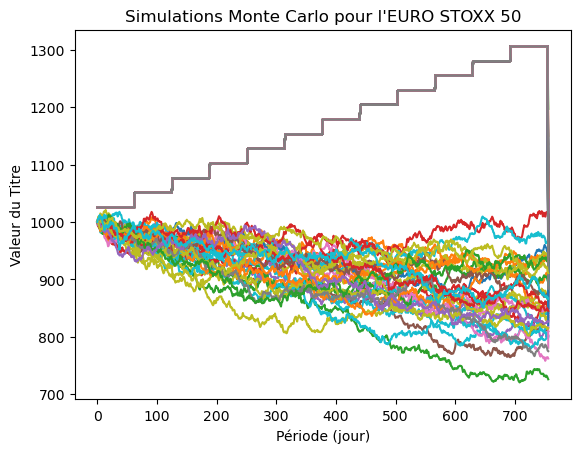

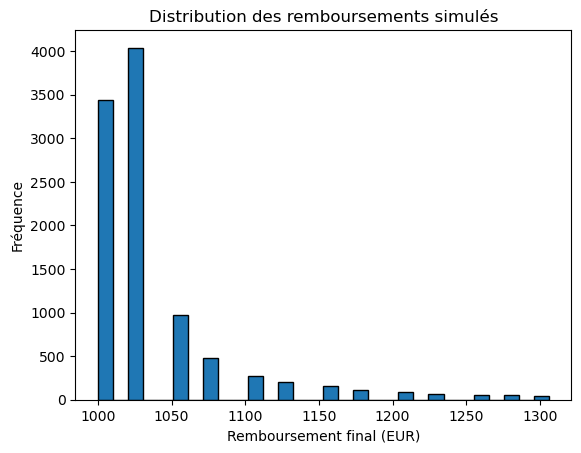

[1076.5 1025.5 1025.5 ... 1153.  1025.5 1025.5]


In [160]:
# Résultats et visualisation 
# Calculer la moyenne des remboursements
mean_final_payout = np.mean(final_payout)
print(f"Remboursement moyen final simulé : {mean_final_payout:.2f} EUR")

# Calculer la probabilité de franchissement de la barrière
prob_barrier = np.mean(barrier_event)
print(f"Probabilité de franchir la barrière activante (60%) : {prob_barrier * 100:.2f}%")

# Calculer la proportion de simulations avec remboursement anticipé
prob_early_redemption = np.mean(early_redemption_flag)
print(f"Probabilité de remboursement anticipé : {prob_early_redemption * 100:.2f}%")

# Visualiser 100 trajectoires simulées
plt.plot(paths[:, :100])
plt.title('Simulations Monte Carlo pour l\'EURO STOXX 50')
plt.xlabel('Période (jour)')
plt.ylabel('Valeur du Titre')
plt.show()

# Visualiser la distribution des remboursements finals
plt.hist(final_payout, bins=30, edgecolor='black')
plt.title('Distribution des remboursements simulés')
plt.xlabel('Remboursement final (EUR)')
plt.ylabel('Fréquence')
plt.show()

max(final_payout)
print(final_payout)

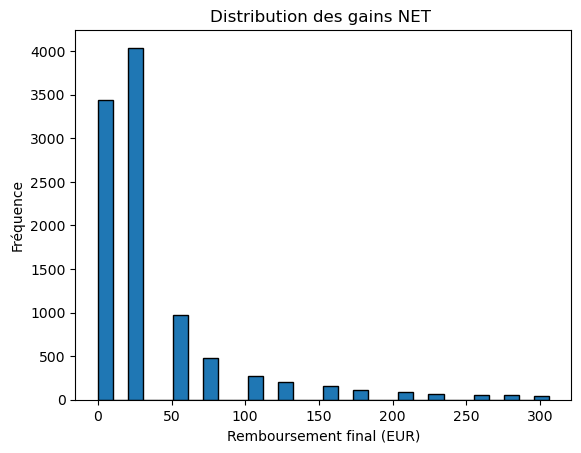

Remboursement moyen final simulé : 1036.64 EUR


In [161]:
# Conclusion et Fair Value du produit

# Visualiser la distribution des remboursements finals
plt.hist(final_payout - 1000, bins=30, edgecolor='black')
plt.title('Distribution des gains NET ')
plt.xlabel('Remboursement final (EUR)')
plt.ylabel('Fréquence')
plt.show()


mean_final_payout = np.mean(final_payout)
print(f"Remboursement moyen final simulé : {mean_final_payout:.2f} EUR")

# Le produit ici verse en moyenne 37.83 EUR
# Il faudrait calculer la fair value en prenant en comptant la taux d'actualisation r (taux sans risque par exemple)
# et donc prendre en compte un taux ajusté pour les remboursements anticipés

# On sent bien aue le modèle de distribution normale des rendements logarithmiques et limité